In [1]:
import torch
from model import ODEBlock, MLP
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
plt.rcParams['font.family'] = 'Times New Roman'


In [2]:
# load model and dataset
t = torch.load("./data/t.pth")
X = torch.load("./data/X_Faultline038065.pth")
dim = X.shape[-1]

In [3]:
def getTestdata(X, FaultDuration = 30):
    if FaultDuration<30 or FaultDuration > 500:
        raise ValueError("Fault Duration out of range.")
    return X[FaultDuration - 30]

# Evaluation

### Neural ODE vs MLP

In [4]:
FaultDuration = 100
model_ode_noisy= ODEBlock(dim,1000,dim)
model_ode_denoisy= ODEBlock(dim,1000,dim)
model_ode_noisy.load_state_dict(torch.load("result/model/ODEBlock_noisy.pth"))
model_ode_denoisy.load_state_dict(torch.load("result/model/ODEBlock_denoisy.pth"))
x_test = getTestdata(X, FaultDuration=FaultDuration)

x0_test = x_test[0]
x_test_hat_noisy =odeint(model_ode_noisy, x0_test, t, method='dopri5').detach()
x_test_hat_denoisy =odeint(model_ode_denoisy, x0_test, t, method='dopri5').detach()

In [5]:
# T = 6
# t = t[:T*100]
# x_test = x_test[:T*100]
# x_test_hat_noisy = x_test_hat_noisy[:T*100]
# x_test_hat_denoisy = x_test_hat_denoisy[:T*100]

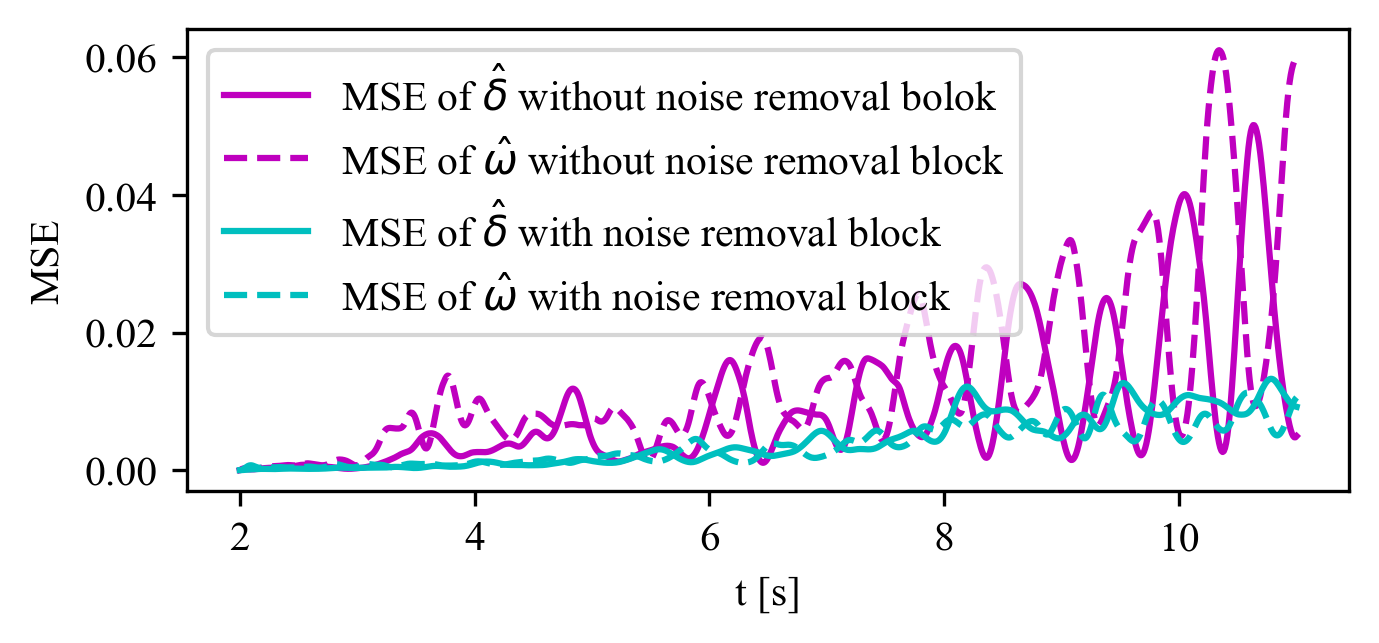

In [6]:

delta_test = x_test[...,0::2]
delta_test_hat_noisy = x_test_hat_noisy[...,0::2]
delta_test_hat_denoisy = x_test_hat_denoisy[...,0::2]

omega_test = x_test[...,1::2]
omega_test_hat_noisy = x_test_hat_noisy[...,1::2]
omega_test_hat_denoisy = x_test_hat_denoisy[...,1::2]

err_noisy_delta = torch.mean(torch.square(delta_test_hat_noisy - delta_test), dim=1)
err_denoisy_delta = torch.mean(torch.square(delta_test_hat_denoisy - delta_test), dim=1)
err_noisy_omega = torch.mean(torch.square(omega_test_hat_noisy - omega_test), dim=1)
err_denoisy_omega = torch.mean(torch.square(omega_test_hat_denoisy - omega_test), dim=1)

plt.figure(figsize=(5,2), dpi=300)
plt.plot(t, err_noisy_delta,'m-', label = "MSE of $\hat{\delta}$ without noise removal bolok")
plt.plot(t, err_noisy_omega,'m--', label = "MSE of $\hat{\omega}$ without noise removal block")
plt.plot(t, err_denoisy_delta,'c-', label = "MSE of $\hat{\delta}$ with noise removal block")
plt.plot(t, err_denoisy_omega,'c--' ,label = "MSE of $\hat{\omega}$ with noise removal block")
plt.xlabel("t [s]")
plt.ylabel("MSE")
plt.legend()
plt.savefig("./result/test result/MSE_2.jpg")